# **Evaluation Function**

In [1]:
video_L = None
video_R = None
snapshot_L = None
snapshot_R = None

def evaluate(model, batch):
    global video_L, video_R, snapshot_L, snapshot_R
    
    # 0) Convert to Gray
    def rgb_to_gray(x):
        weights = torch.tensor([0.2989, 0.5870, 0.1140], dtype=x.dtype, device=x.device)
        gray = (x * weights[None, None, :, None, None]).sum(dim=2)
        return gray # -- shape: [B, T, H, W]
    
    video_L = rgb_to_gray(batch["img"][:, :, 0]) # ~ (b, t, h, w)
    video_R = rgb_to_gray(batch["img"][:, :, 1]) # ~ (b, t, h, w)
    
    # 1) Extract and normalize input videos.
    # -- min_max_norm = lambda x : 2. * (x / 255.) - 1.
    min_max_norm = lambda x: x / 255.
    video_L = min_max_norm(video_L) # ~ (b, t, h, w)
    video_R = min_max_norm(video_R) # ~ (b, t, h, w)
    
    # 2) If the tensor is non-contiguous and we try .view() later, PyTorch will raise an error:
    video_L = video_L.contiguous()
    video_R = video_R.contiguous()
    
    # 3) Coded exposure modeling.
    snapshot_L = model.sci_enc_L(video_L) # ~ (b, c, h, w) -- c=2 for 2 taps
    snapshot_R = model.sci_enc_R(video_R) # ~ (b, c, h, w) -- c=2 for 2 taps
    
    # 4) Dynamic Stereo
    output = {}
    
    disparities = model.stereo(
        snapshot_L,
        snapshot_R,
        iters=10,
        test_mode=False
    )

    snapshot_L = snapshot_L.detach().numpy()
    snapshot_R = snapshot_R.detach().numpy()
    
    return disparities

# **Model Setup and Testing on Dynamic Stereo Real-World Dataset** 

In [3]:
import sys
import torch

sys.path.append("../")

import datasets.dynamic_stereo_datasets as datasets
from train import wrapper

model = wrapper(sigma_range=[0, 1e-9],
                num_frames=8,
                in_channels=1,
                n_taps=2,
                resolution=[480, 640],
                mixed_precision=True,
                attention_type="self_stereo_temporal_update_time_update_space",
                update_block_3d=True,
                different_update_blocks=True,
                train_iters=8)

ckpt_path = "../dynamicstereo_sf_dr/model_dynamic-stereo_050895.pth"
state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict["model"], strict=True)
model.eval()

for seq_name in ["nikita_reading", "ignacio_waving", "teddy_static"]:
    real_dataset = datasets.DynamicReplicaDataset(split="test",
                                                  sample_len=8,
                                                  root="../dynamic_replica_data/real/{}".format(seq_name),
                                                  only_first_n_samples=1,
                                                  t_step_validation=8)
    break

for batch in real_dataset:
    batch["img"] = batch["img"].view(1, *batch["img"].shape)
    batch_ = {}
    for k, v in batch.items():
        if k == "img" or k == "mask":
            batch_[k] = v[..., 100:, 400:]
        else:
            batch_[k] = v
    disparities = evaluate(model, batch_)

seq_len Nikita_reading_new 83
Added 1 from Dynamic Replica test


## **Disparity Maps (Left Aligned)**

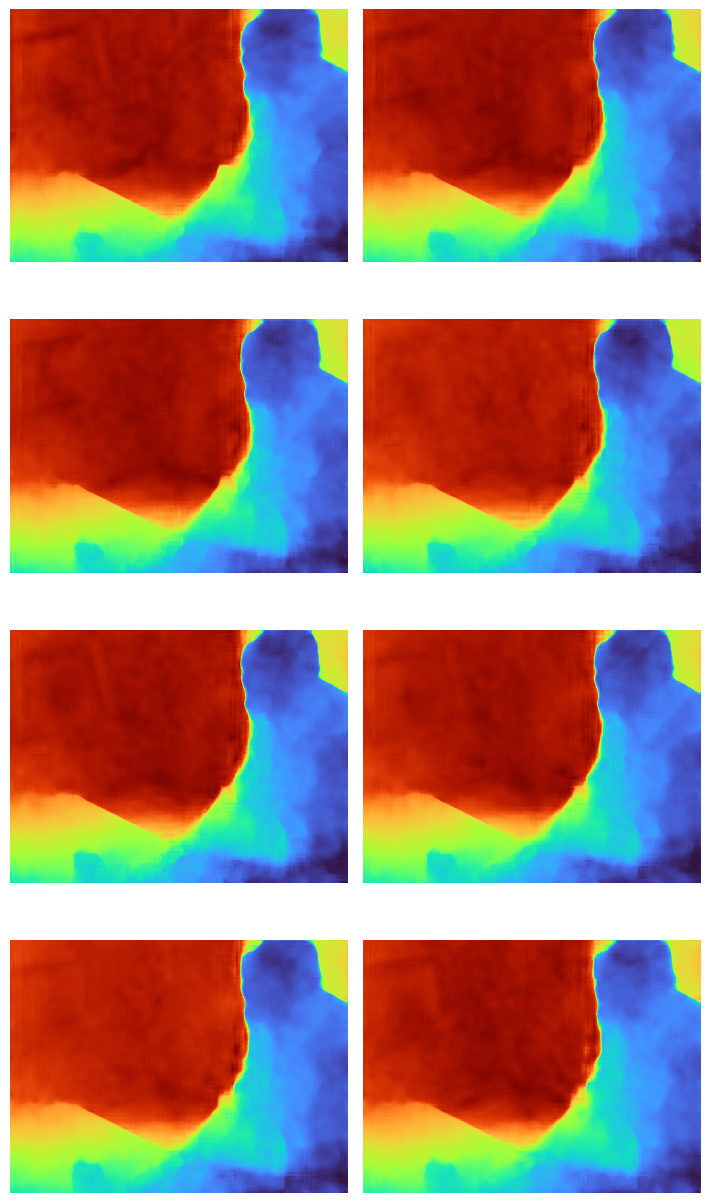

In [4]:
import matplotlib.pyplot as plt
import numpy as np

disparities = disparities.detach().cpu()

fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(disparities[-1, i, 0, 0], cmap="turbo")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

disparity = disparities[-1, :, 0, 0].detach().numpy()

frames = []

for t in range(disparity.shape[0]):
    disp = disparity[t]

    # Normalize to 0–255 for visualization
    disp_norm = (disp - disp.min()) / (disp.max() - disp.min())
    disp_uint8 = (disp_norm * 255).astype(np.uint8)

    # Convert colormap to RGB image
    cmap = plt.get_cmap("turbo")  # or 'plasma', 'magma', etc.
    rgb = (cmap(disp_uint8)[:, :, :3] * 255).astype(np.uint8)

    frames.append(rgb)

# Save GIF (duration is time per frame in seconds)
imageio.mimsave("disparity.gif", frames, duration=0.2)


# **Video (Left View)**

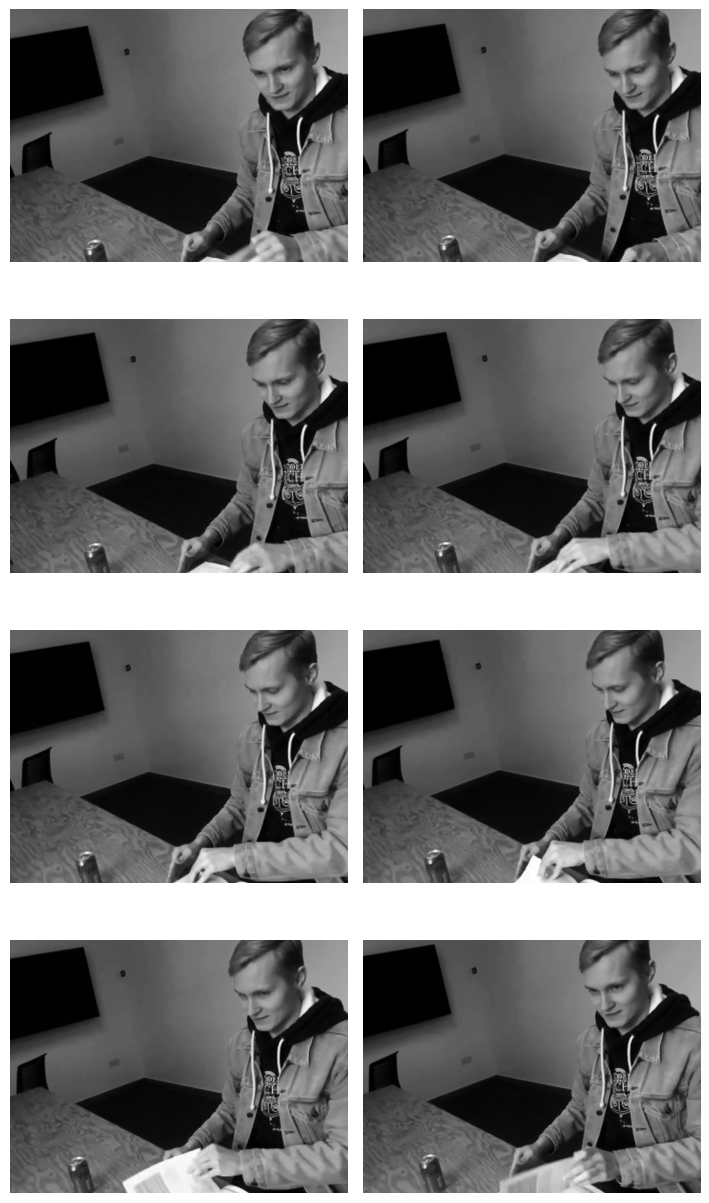

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_L[0, i, ..., :480, :640], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [22]:
import numpy as np
import imageio

# disparity: numpy array with shape (8, 480, 640)

frames = []

for t in range(8):
    frame = video_L[0, t, ..., :480, :640].detach().numpy()

    # Normalize to 0–255
    # norm = (frame - frame.min()) / (frame.max() - frame.min())
    img = (frame * 255).astype(np.uint8)

    frames.append(img)

# Save as grayscale GIF
imageio.mimsave("left_view.gif", frames, duration=0.2)


# **Video (Right View)**

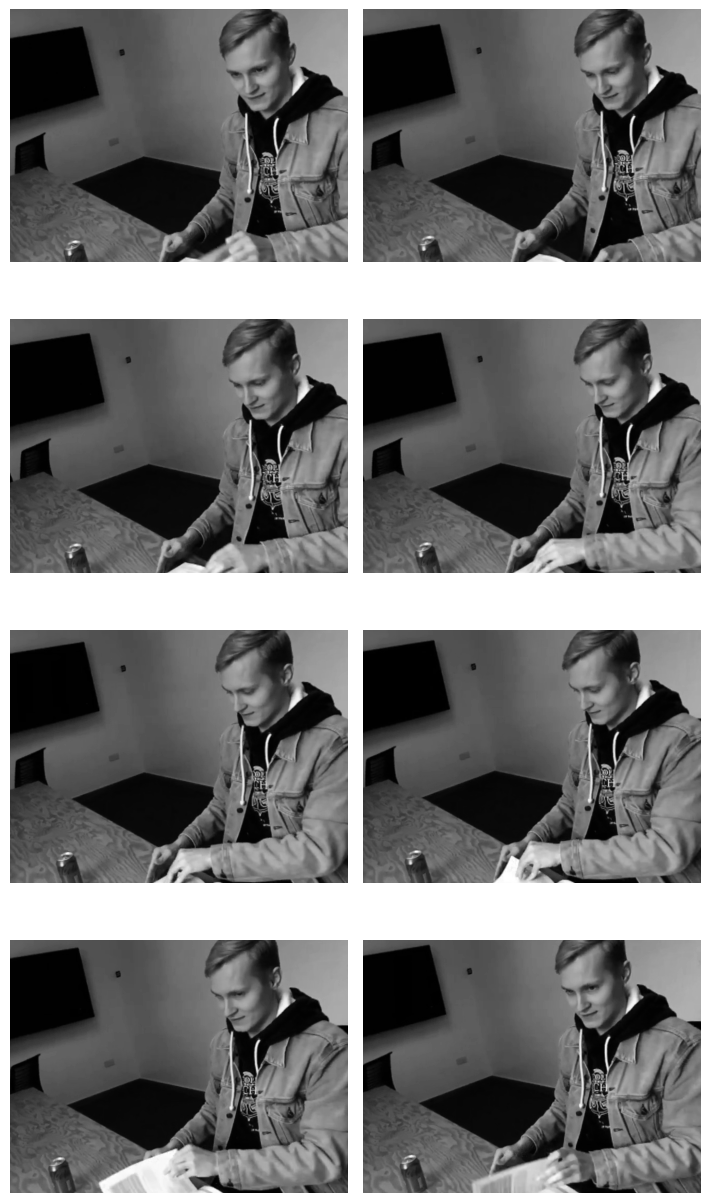

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_R[0, i, ..., :480, :640], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Snapshots and Shutter Code (Left View)**

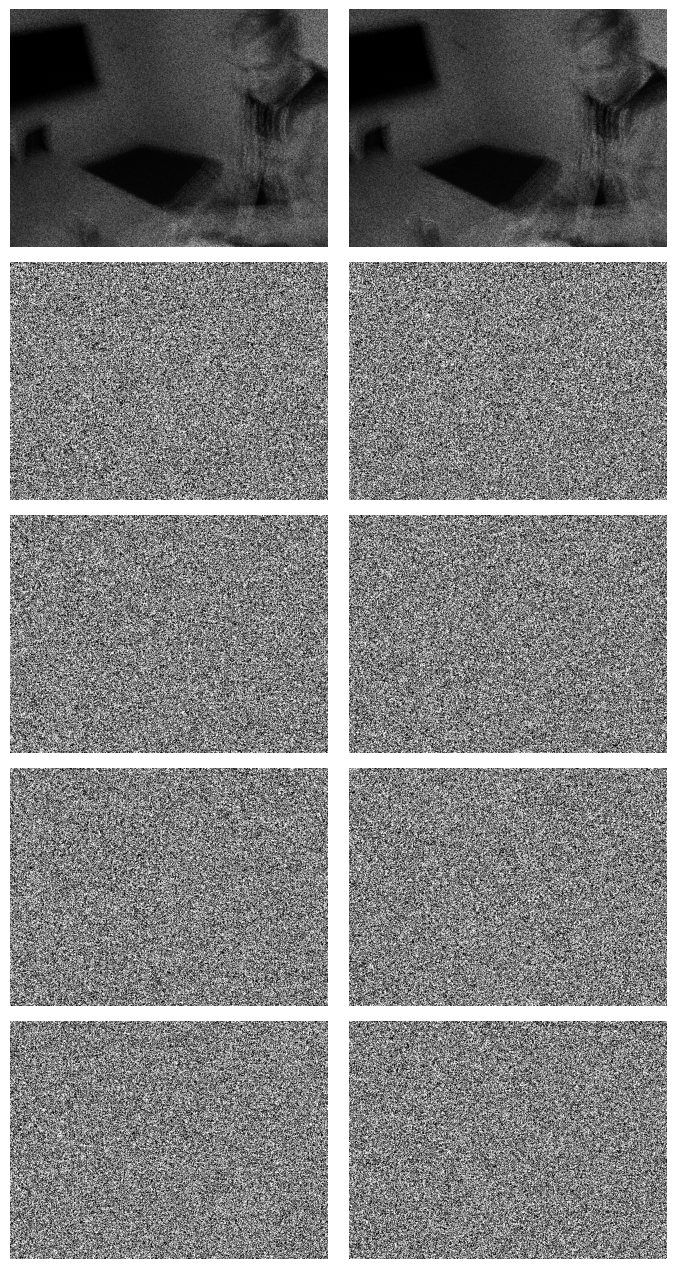

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(snapshot_L[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **SCI Encoder's Weights (Left)**

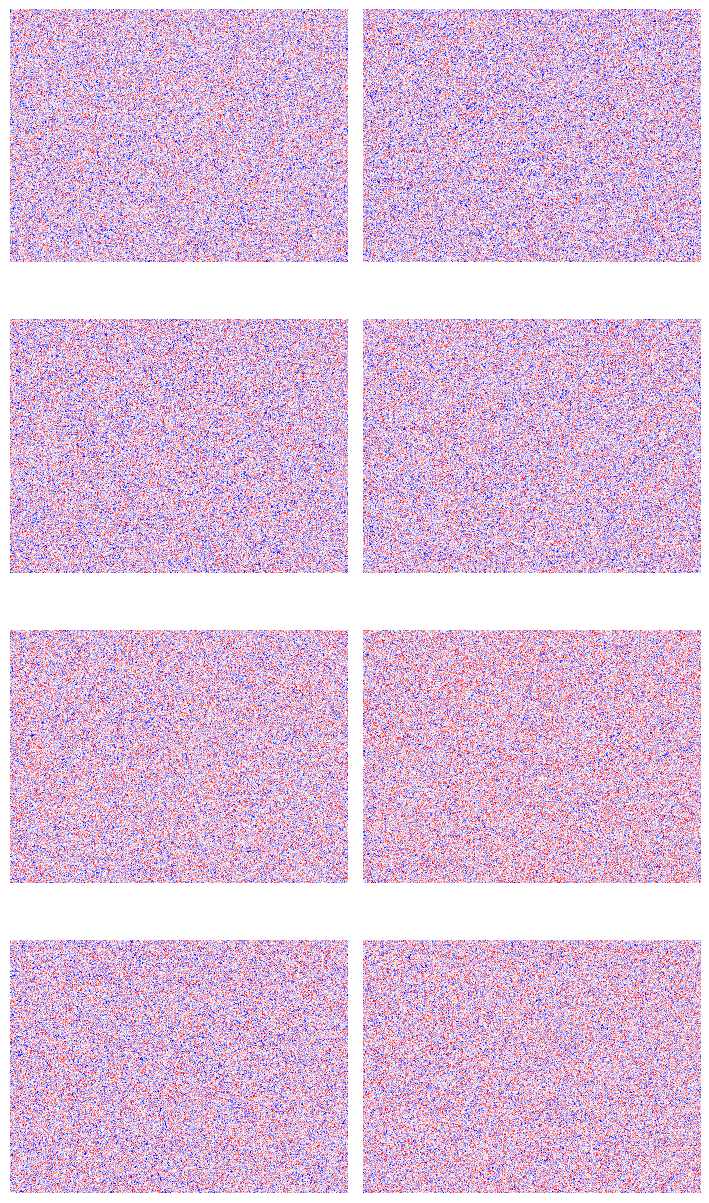

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(model.sci_enc_L.ce_weight.detach().numpy()[i, 0], cmap="seismic")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Snapshots and Shutter Code (Right View)**

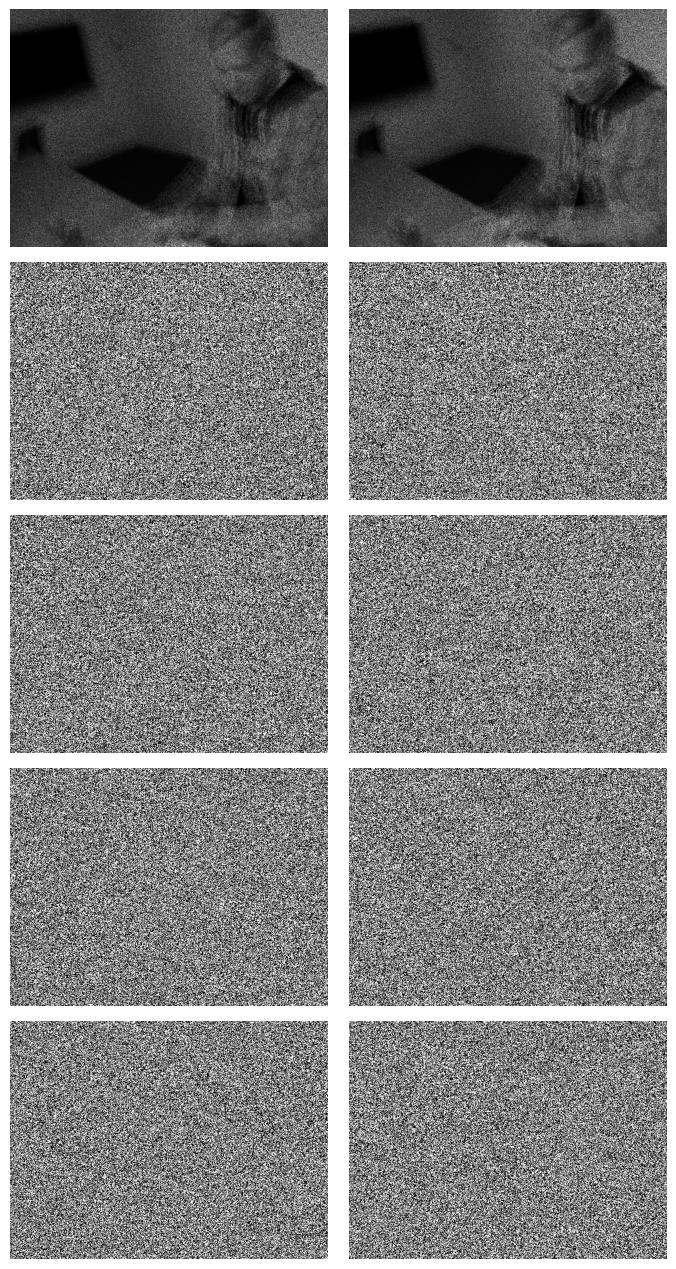

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(snapshot_R[0, i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **SCI Encoder's Weights (Right)**

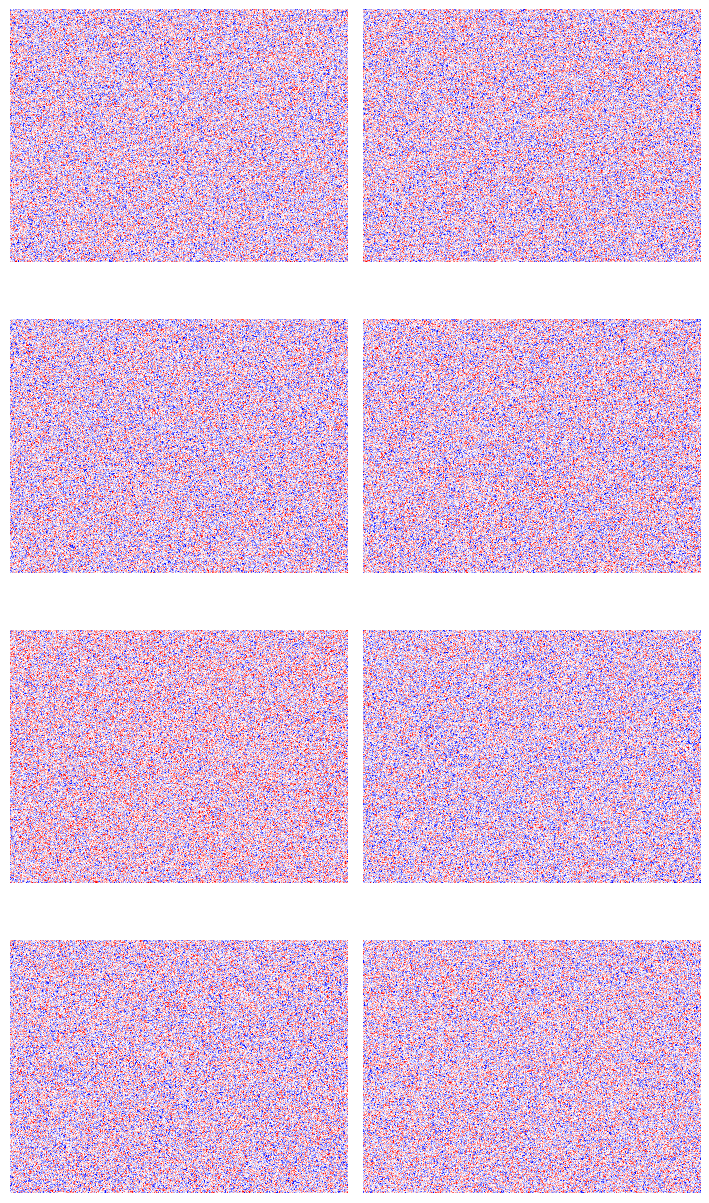

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(7.2, 12.8))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(model.sci_enc_R.ce_weight.detach().numpy()[i, 0], cmap="seismic")
    ax.axis("off")
plt.tight_layout()
plt.show()

# **Novel View Synthesis**

In [3]:
from collections import defaultdict
import configparser
import os
import math
from typing import Optional, List
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from dataclasses import dataclass
from tabulate import tabulate
import imageio

from pytorch3d.structures import Pointclouds
from pytorch3d.transforms import RotateAxisAngle
from pytorch3d.utils import (
    opencv_from_cameras_projection,
)
from pytorch3d.renderer import (
    AlphaCompositor,
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
)

from tqdm import tqdm
from omegaconf import DictConfig
from pytorch3d.implicitron.tools.config import Configurable
from typing import Dict, Optional, Union

In [4]:
def depth_to_pcd(
    depth_map,
    img,
    focal_length,
    cx,
    cy,
    step: int = None,
    inv_extrinsic=None,
    mask=None,
    filter=False,
):
    __, w, __ = img.shape
    if step is None:
        step = int(w / 100)
    Z = depth_map[::step, ::step]
    colors = img[::step, ::step, :]

    Pixels_Y = torch.arange(Z.shape[0]).to(Z.device) * step
    Pixels_X = torch.arange(Z.shape[1]).to(Z.device) * step

    X = (Pixels_X[None, :] - cx) * Z / focal_length
    Y = (Pixels_Y[:, None] - cy) * Z / focal_length

    inds = Z > 0

    if mask is not None:
        inds = inds * (mask[::step, ::step] > 0)

    X = X[inds].reshape(-1)
    Y = Y[inds].reshape(-1)
    Z = Z[inds].reshape(-1)
    colors = colors[inds]
    pcd = torch.stack([X, Y, Z]).T

    if inv_extrinsic is not None:
        pcd_ext = torch.vstack([pcd.T, torch.ones((1, pcd.shape[0])).to(Z.device)])
        pcd = (inv_extrinsic @ pcd_ext)[:3, :].T

    if filter:
        pcd, filt_inds = filter_outliers(pcd)
        colors = colors[filt_inds]
    return pcd, colors




In [5]:
@dataclass
class PerceptionPrediction:
    """
    Holds the tensors that describe a result of any perception module.
    """

    depth_map: Optional[torch.Tensor] = None
    disparity: Optional[torch.Tensor] = None
    image_rgb: Optional[torch.Tensor] = None
    fg_probability: Optional[torch.Tensor] = None


In [6]:
def visualize_batch(
    batch_dict: dict,
    preds: PerceptionPrediction,
    output_dir: str,
    ref_frame: int = 0,
    only_foreground=False,
    step=0,
    sequence_name=None,
    writer=None,
    # -- Added by Chu King on 22nd November 2025 to fix image resolution during evaluation.
    resolution=[480, 640]
):
    os.makedirs(output_dir, exist_ok=True)

    outputs = {}

    if preds.depth_map is not None:
        device = preds.depth_map.device

        print ("[INFO] :", batch_dict["stereo_video"].shape)

        pcd_global_seq = []
        # -- H, W = batch_dict["stereo_video"].shape[3:]
        H, W = resolution

        for i in range(len(batch_dict["stereo_video"])):
            R, T, K = opencv_from_cameras_projection(
                preds.perspective_cameras[i],
                torch.tensor([H, W])[None].to(device),
            )

            extrinsic_3x4_0 = torch.cat([R[0], T[0, :, None]], dim=1)

            extr_matrix = torch.cat(
                [
                    extrinsic_3x4_0,
                    torch.Tensor([[0, 0, 0, 1]]).to(extrinsic_3x4_0.device),
                ],
                dim=0,
            )

            inv_extr_matrix = extr_matrix.inverse().to(device)
            pcd, colors = depth_to_pcd(
                preds.depth_map[i, 0],
                batch_dict["stereo_video"][..., :resolution[0], : resolution[1]][i][0].permute(1, 2, 0),
                K[0][0][0],
                K[0][0][2],
                K[0][1][2],
                step=1,
                inv_extrinsic=inv_extr_matrix,
                mask=batch_dict["fg_mask"][..., :resolution[0], : resolution[1]][i, 0] if only_foreground else None,
                filter=False,
            )

            R, T = inv_extr_matrix[None, :3, :3], inv_extr_matrix[None, :3, 3]
            pcd_global_seq.append((pcd, colors, (R, T, preds.perspective_cameras[i])))

        raster_settings = PointsRasterizationSettings(
            image_size=[H, W], radius=0.003, points_per_pixel=10
        )
        R, T, cam_ = pcd_global_seq[ref_frame][2]

        median_depth = preds.depth_map.median()
        # -- cam_.cuda()

        for mode in ["angle_15", "angle_-15", "changing_angle"]:
            res = []

            for t, (pcd, color, __) in enumerate(pcd_global_seq):

                if mode == "changing_angle":
                    angle = math.cos((math.pi) * (t / 15)) * 15
                elif mode == "angle_15":
                    angle = 15
                elif mode == "angle_-15":
                    angle = -15

                delta_x = median_depth * math.sin(math.radians(angle))
                delta_z = median_depth * (1 - math.cos(math.radians(angle)))

                cam = cam_.clone()
                cam.R = torch.bmm(
                    cam.R,
                    RotateAxisAngle(angle=angle, axis="Y", device=device).get_matrix()[
                        :, :3, :3
                    ],
                )
                cam.T[0, 0] = cam.T[0, 0] - delta_x
                cam.T[0, 2] = cam.T[0, 2] - delta_z + median_depth / 2.0

                rasterizer = PointsRasterizer(
                    cameras=cam, raster_settings=raster_settings
                )
                renderer = PointsRenderer(
                    rasterizer=rasterizer,
                    compositor=AlphaCompositor(background_color=(1, 1, 1)),
                )
                pcd_copy = pcd.clone()

                point_cloud = Pointclouds(points=[pcd_copy], features=[color / 255.0])
                images = renderer(point_cloud)
                res.append(images[0, ..., :3].cpu())
            res = torch.stack(res)

            video = (res * 255).numpy().astype(np.uint8)
            save_name = f"{sequence_name}_reconstruction_{step}_mode_{mode}_"
            if writer is None:
                outputs[mode] = video
            if only_foreground:
                save_name += "fg_only"
            else:
                save_name += "full_scene"
            video_out = cv2.VideoWriter(
                os.path.join(
                    output_dir,
                    f"{save_name}.mp4",
                ),
                cv2.VideoWriter_fourcc(*"mp4v"),
                fps=10,
                frameSize=(res.shape[2], res.shape[1]),
                isColor=True,
            )

            for i in range(len(video)):
                video_out.write(cv2.cvtColor(video[i], cv2.COLOR_BGR2RGB))
            video_out.release()

            if writer is not None:
                writer.add_video(
                    f"{sequence_name}_reconstruction_mode_{mode}",
                    (res * 255).permute(0, 3, 1, 2).to(torch.uint8)[None],
                    global_step=step,
                    fps=8,
                )

    return outputs

In [7]:
def eval_batch(batch_dict, predictions, resolution=[480, 640]) -> Dict[str, Union[float, torch.Tensor]]:
    results = {}

    mask_now = torch.ones_like(batch_dict["fg_mask"][..., :resolution[0], :resolution[1]])

    mask_now = mask_now * batch_dict["disparity_mask"][..., :resolution[0], :resolution[1]]

    eval_flow_traj_output = eval_endpoint_error_sequence(
        predictions["disparity"], batch_dict["disparity"][..., :resolution[0], :resolution[1]], mask_now
    )
    for epe_name in ("epe", "temp_epe"):
        results[PerceptionMetric(f"disp_{epe_name}_mean")] = eval_flow_traj_output[
            f"{epe_name}_mean"
        ]

        results[PerceptionMetric(f"disp_{epe_name}_bad_3px")] = eval_flow_traj_output[
            f"{epe_name}_bad_3px"
        ]

        results[PerceptionMetric(f"disp_{epe_name}_bad_2px")] = eval_flow_traj_output[
            f"{epe_name}_bad_2px"
        ]

        results[PerceptionMetric(f"disp_{epe_name}_bad_1px")] = eval_flow_traj_output[
            f"{epe_name}_bad_1px"
        ]

        results[PerceptionMetric(f"disp_{epe_name}_bad_0.5px")] = eval_flow_traj_output[
            f"{epe_name}_bad_0.5px"
        ]
    if "endpoint_error_per_pixel" in eval_flow_traj_output:
        results["disp_endpoint_error_per_pixel"] = eval_flow_traj_output[
            "endpoint_error_per_pixel"
        ]
    return (results, len(predictions["disparity"]))

In [8]:
def pretty_print_perception_metrics(results):

    metrics = sorted(list(results.keys()), key=lambda x: x.metric)

    print("===== Perception results =====")
    print(
        tabulate(
            [[metric, results[metric]] for metric in metrics],
        )
    )

In [9]:
def depth2disparity_scale(left_camera, right_camera, image_size_tensor):
    # # opencv camera matrices
    (_, T1, K1), (_, T2, _) = [
        opencv_from_cameras_projection(
            f,
            image_size_tensor,
        )
        for f in (left_camera, right_camera)
    ]
    fix_baseline = T1[0][0] - T2[0][0]
    focal_length_px = K1[0][0][0]
    # following this https://github.com/princeton-vl/RAFT-Stereo#converting-disparity-to-depth
    return focal_length_px * fix_baseline

In [12]:
@torch.no_grad()
def evaluate_sequence(
    model,
    test_dataloader: torch.utils.data.DataLoader,
    is_real_data: bool = False,
    step=None,
    writer=None,
    train_mode=False,
    interp_shape=None,
    resolution=[480, 640],
    eps=1e-5,
    visualize_dir="./visualize/",
    row_offset=100,
    col_offset=400
):
    # -- Modified by Chu King on 20th November 2025 for SCI Stereo.
    # -- model.eval()
    per_batch_eval_results = []
    os.makedirs(visualize_dir, exist_ok=True)
    for batch_idx, sequence in enumerate(tqdm(test_dataloader)):
        if is_real_data:
            sequence["img"] = sequence["img"].contiguous().view((1, *sequence["img"].shape))
            sequence["mask"] = sequence["mask"].contiguous().view((1, *sequence["mask"].shape))
            sequence["img"] = sequence["img"][..., row_offset:, col_offset:]
            sequence["mask"] = sequence["mask"][..., row_offset:, col_offset:]
            
        batch_dict = defaultdict(list)
        batch_dict["stereo_video"] = sequence["img"][0]
        
        if not is_real_data:
            batch_dict["disparity"] = sequence["disp"][:, 0].abs()
            batch_dict["disparity_mask"] = sequence["valid_disp"][:, :1] # ~ (T, 1, 720, 1280)
            if "mask" in sequence:
                batch_dict["fg_mask"] = sequence["mask"][:, :1]
            else:
                batch_dict["fg_mask"] = torch.ones_like(
                    batch_dict["disparity_mask"]
                )
        elif interp_shape is not None:
            left_video = batch_dict["stereo_video"][:, 0]
            left_video = F.interpolate(
                left_video, tuple(interp_shape), mode="bilinear"
            )
            right_video = batch_dict["stereo_video"][:, 1]
            right_video = F.interpolate(
                right_video, tuple(interp_shape), mode="bilinear"
            )
            batch_dict["stereo_video"] = torch.stack([left_video, right_video], 1)

        predictions = evaluate(model, sequence)
        
        # == predictions["disparity"] = predictions["disparity"][:, :1].clone().cpu()
        predictions = {"disparity": predictions[-1, :, :, 0, :, :].clone().cpu()}
        # -- predictions["disparity"] = predictions["disparity"][:, :1].clone().cpu()
        
        print (predictions["disparity"].shape)
        if not is_real_data:
            predictions["disparity"] = predictions["disparity"] * (
                # -- Modified by Chu King on 22nd November 2025
                # -- batch_dict["disparity_mask"].round()
                batch_dict["disparity_mask"][..., :resolution[0], :resolution[1]].round()
            )
            batch_eval_result, seq_length = eval_batch(batch_dict, predictions)
            per_batch_eval_results.append((batch_eval_result, seq_length))
            pretty_print_perception_metrics(batch_eval_result)
            
        # -- Visualization
        perception_prediction = PerceptionPrediction()
        pred_disp = predictions["disparity"]
        pred_disp[pred_disp < eps] = eps
        
        scale = depth2disparity_scale(
            sequence["viewpoint"][0][0],
            sequence["viewpoint"][0][1],
            torch.tensor([pred_disp.shape[2], pred_disp.shape[3]])[None],
        )
        perception_prediction.depth_map = scale / pred_disp
        perspective_cameras = []
        
        for cam in sequence["viewpoint"]:
            perspective_cameras.append(cam[0])
        perception_prediction.perspective_cameras = perspective_cameras
        
        # -- Modified by Chu King on 22nd November 2025 to fix image resolution during training.
        if "stereo_original_video" in batch_dict:
            batch_dict["stereo_video"] = batch_dict["stereo_original_video"][..., :resolution[0], :resolution[1]].clone()

        """
        for k, v in batch_dict.items():
            if isinstance(v, torch.Tensor):
                batch_dict[k] = v.cuda()
        """
                
        visualize_batch(
            batch_dict,
            perception_prediction,
            output_dir=visualize_dir,
            sequence_name=sequence["metadata"][0][0][0],
            step=step,
            writer=writer,
            # -- Added by Chu King on 22nd November 2025 to fix image resolution during evaluation.
            resolution=resolution
        )
    return per_batch_eval_results

In [13]:
results = evaluate_sequence(model=model,
                            test_dataloader=real_dataset,
                            is_real_data=True)

  0%|                                                    | 0/1 [00:00<?, ?it/s]

torch.Size([8, 1, 480, 640])
[INFO] : torch.Size([8, 2, 3, 620, 880])


100%|████████████████████████████████████████| 1/1 [1:08:12<00:00, 4092.92s/it]


In [49]:
import cv2
import numpy as np
import imageio

video = cv2.VideoCapture("./visualize/teddy2_sample_new_reconstruction_None_mode_changing_angle_full_scene.mp4")
overlay = cv2.imread("../images/inference_procedure.png", cv2.IMREAD_UNCHANGED)

# Resize overlay to match video height
frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
scale = frame_h / overlay.shape[0]
overlay = cv2.resize(overlay, None, fx=scale, fy=scale)

frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break

    ov_h, ov_w = overlay.shape[:2]

    # Split overlay into RGB + Alpha
    ov_rgb = overlay[:, :, :3]
    ov_a = overlay[:, :, 3] / 255.0
    ov_a = ov_a[:, :, None]

    # Choose white background (or any RGB color)
    bg = np.ones_like(ov_rgb) * 255

    # Alpha blend overlay onto white background
    blended_left = (ov_a * ov_rgb + (1 - ov_a) * bg).astype(np.uint8)

    # Create combined frame (RGB)
    tmp = np.zeros((ov_h, ov_w + frame.shape[1], 3), dtype=np.uint8)

    # Place blended overlay on left
    tmp[:, :ov_w] = blended_left

    # Place video frame on right
    tmp[:, ov_w:] = frame

    # Slow down video x4
    for _ in range(4):
        frames.append(tmp)

video.release()

imageio.mimsave("output.gif", frames, fps=10)


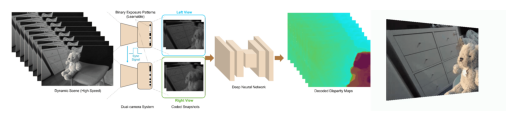

In [50]:
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image

def play_gif_with_matplotlib(gif_path):
    """Reads a GIF file and displays it as a Matplotlib animation."""
    
    # Open the GIF file using Pillow
    img = Image.open(gif_path)
    
    # Extract all frames
    frames = []
    try:
        while True:
            # Convert the current frame to a NumPy array (Image data)
            frames.append(np.asarray(img.convert('RGB')))
            img.seek(img.tell() + 1) # Move to the next frame
    except EOFError:
        pass # Reached the end of the GIF file
        
    # --- Matplotlib Setup ---
    
    # 1. Create a figure and axes
    fig, ax = plt.subplots()
    ax.axis('off') # Hide axis ticks and labels

    # 2. Display the first frame
    # The 'im' object will be updated in the animation function
    im = ax.imshow(frames[0])

    # 3. Define the update function for the animation
    def update(frame):
        # Update the image data to display the next frame
        im.set_array(frames[frame])
        return [im]

    # 4. Create the animation object
    # interval: delay between frames in milliseconds (1000/FPS)
    ani = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(frames), 
        interval=img.info.get('duration', 100), # Use GIF's frame duration if available, otherwise 100ms
        blit=True, 
        repeat=True
    )

    # 5. Display the animation
    plt.show()

# --- Example Usage ---
# NOTE: Replace 'my_animation.gif' with the actual path to your GIF file.
# You need a GIF file available for this to work.
play_gif_with_matplotlib('output.gif')